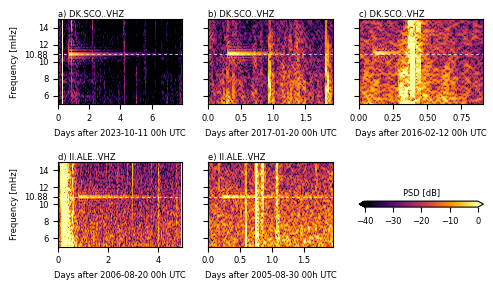

In [4]:
from obspy import read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

known_events = [
    {
        "date": "2023-10-11",
        "time": "16:30:00.0Z",
        "station": "DK.SCO",
        "waveform_folder": "waveforms",
        "n_days": 8,
        "ax_id": 0,
    },
    {
        "date": "2017-01-20",
        "time": "08:10:00.0Z",
        "station": "DK.SCO",
        "waveform_folder": "waveforms",
        "n_days": 2,
        "ax_id": 1,
    },
    {
        "date": "2016-02-12",
        "time": "04:10:00.0Z",
        "station": "DK.SCO",
        "waveform_folder": "waveforms",
        "n_days": 1,
        "ax_id": 2,
    },
    {
        "date": "2006-08-20",
        "time": "19:50:00.0Z",
        "station": "II.ALE",
        "waveform_folder": "waveforms",
        "n_days": 5,
        "ax_id": 3,
    },
    {
        "date": "2005-08-30",
        "time": "06:00:00.0Z",
        "station": "II.ALE",
        "waveform_folder": "waveforms",
        "n_days": 2,
        "ax_id": 4,
    },
]

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(5, 3))
labels = [
    "a)",
    "b)",
    "c)",
    "d)",
    "e)",
]

for idx, event in enumerate(known_events):
    ax = axs.flatten()[event["ax_id"]]
    n_days = event["n_days"]
    time = UTCDateTime(event["date"] + "T" + event["time"])
    endtime = UTCDateTime(event["date"]) + n_days * 24 * 60 * 60

    read_str = (
        f"{event['waveform_folder']}/{event['station']}*{time.year}{time.month:02d}*"
    )
    st = read(read_str)

    if event["date"] == "2005-08-30":
        st += read(
            f"{event['waveform_folder']}/{event['station']}*{time.year}{time.month+1:02d}*",
        )

    st.trim(UTCDateTime(event["date"]), endtime)
    st.merge()

    tr = st[0]
    try:
        f, t, Sxx = spectrogram(
            tr.data,
            fs=tr.stats.sampling_rate,
            # nperseg=3600,
            # noverlap=2400,
            # nfft=3600,
            nperseg=360,
            noverlap=350,
            nfft=10 * 360,
        )
    except:
        continue
    
    # to mHz
    f *= 1e3
    # to dB
    Sxx = 10 * np.log10(Sxx)

    # cut to band for inspection
    freq_idx = np.where((f >= 5) & (f <= 15))[0]
    f = f[freq_idx]
    Sxx = Sxx[freq_idx, :]

    # zoomin time
    ylim = ([8, 13],)
    time_idx = np.where(
        (time - tr.stats.starttime - 2400 <= t)
        & (t <= time - tr.stats.starttime + 2400)
    )

    Sxx -= np.nanmax(Sxx[:, time_idx[0]])

    Sxx_zoom = Sxx[:, time_idx[0]]

    # relative to max
    t_days = (t - t[0]) / (24 * 60 * 60)

    pcm = ax.pcolorfast(t_days, f, Sxx, vmin=-40, vmax=0, cmap="inferno")
    ax.set(
        ylim=[5, 15],
        yticks=[6, 8, 10, 10.88, 12, 14],
        yticklabels=[6, 8, 10, 10.88, 12, 14],
        xlabel=f"Days after {tr.stats.starttime.year}-{tr.stats.starttime.month:02d}-{tr.stats.starttime.day:02d} 00h UTC",
    )

    ax.set_title(
        f'{labels[idx]} {event["station"]}..VHZ', fontsize=6, loc="left", pad=0
    )

    # ticks smaller
    ax.tick_params(axis="both", which="major", labelsize=6)
    # labels smaller
    ax.set_xlabel(ax.get_xlabel(), fontsize=6)

    ax.axhline(10.88, c="white", dashes=(4, 4), lw=0.5)

plt.tight_layout()
# horizontal colorbar in plane of axs[-1, -1]
x0, y0, width, height = axs[-1, -1].get_position().bounds
cax = fig.add_axes([x0, y0 + height / 2 - 0.01, width, 0.02])
fig.colorbar(pcm, cax=cax, extend="both", label="PSD [dB]", orientation="horizontal")
# colorbar label on top
cax.xaxis.set_label_position("top")
cax.tick_params(axis="both", which="major", labelsize=6)
# label font smaller
cax.set_xlabel(cax.get_xlabel(), fontsize=6)

axs[0, 0].set(ylabel="Frequency [mHz]")
axs[0, 0].set_ylabel(axs[0, 0].get_ylabel(), fontsize=6)
axs[1, 0].set(ylabel="Frequency [mHz]")
axs[1, 0].set_ylabel(axs[1, 0].get_ylabel(), fontsize=6)

last_ax = axs.flat[-1]
last_ax.set_visible(False)